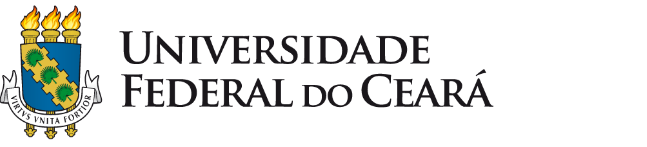

## Classificação de Imagens com o Dataset Médico (Pneumonia)

Disciplina: Sistema Distribuidos

Aluno: Ernesto Gurgel Valente Neto

Prof. Dr. Julio Anjos

## Dataset Médico (Pneumologia)

Reconhecimento
[Dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2)

License: CC BY 4.0
[Citation](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

[DOI](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)


## GPU
Ativiação e Validação das GPU e Memoria adicional

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 30 19:40:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Carregando as bibliotecas (pyhton)

In [3]:
#Importação das bibliotecas
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Carregando dados de serviço da nuvem

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
main_path = "/content/drive/MyDrive/archive/chest_xray"

#NOVO

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tensorflow as tf

train_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg"))
train_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg"))

test_normal = glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg"))
test_pneumonia = glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg"))

val_normal = glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))
val_pneumonia = glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))



In [7]:
df_train = pd.DataFrame({
    'class': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia),
    'image': train_normal + train_pneumonia
})

df_test = pd.DataFrame({
    'class': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia),
    'image': test_normal + test_pneumonia
})

df_val = pd.DataFrame({
    'class': ['Normal'] * len(val_normal) + ['Pneumonia'] * len(val_pneumonia),
    'image': val_normal + val_pneumonia
})

Este código está criando três DataFrames do pandas (**df_train, df_test e df_valid**)

a partir das listas de imagens de treinamento, teste e validação que foram previamente definidas.

Cada DataFrame tem duas colunas:

* A coluna 'class' indica a classe da imagem. As imagens são rotuladas como
* 'Normal' ou 'Pneumonia'. A expressão `['Normal'] * len(train_normal)` cria uma lista que contém a string 'Normal' repetida o número de vezes igual ao tamanho de `train_normal`, que é o número de imagens normais no conjunto de treinamento. O mesmo é feito para a classe 'Pneumonia' com `['Pneumonia'] * len(train_pneumonia)`. As duas listas são então concatenadas juntas com o operador `+`, resultando em uma lista que tem a string 'Normal' para cada imagem normal e a string 'Pneumonia' para cada imagem com pneumonia.
*  A coluna 'image' contém os caminhos para as imagens. Similarmente à coluna 'class', os caminhos para as imagens normais e de pneumonia são concatenados juntos para formar uma única lista.

Separando os dataset em conjuntos de dados de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

#Embaralhamento do dataset antes da divisão
df_all = df_all.sample(frac=1).reset_index(drop=True)

# Primeiro, dividimos o conjunto de dados em treinamento (80%) e teste (20%)
df_train, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all['class'], random_state=42)

# Então dividimos o conjunto de treinamento em treinamento (80%) e validação (20%)
df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train['class'], random_state=42)

# Redefinindo o índice para poder validar os dados divididos
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Explorando os dados do MÉDICOS

O método shape retorna uma tupla representando as dimensões do DataFrame. A primeira entrada da tupla é o **número de linhas** e a **segunda é o número de colunas**.

* df_train.shape retorna o formato do DataFrame de treinamento, que contém as imagens e rótulos que serão usados para treinar o modelo.
* df_test.shape retorna o formato do DataFrame de teste, que contém as imagens e rótulos que serão usados para avaliar a performance do modelo depois que ele foi treinado.
* df_valid.shape retorna o formato do DataFrame de validação, que contém as imagens e rótulos que podem ser usados para ajustar os parâmetros do modelo durante o treinamento (embora a maneira como esses conjuntos de dados são usados possa variar dependendo da abordagem específica de modelagem usada).

In [12]:
print("data frame:\n", pd.concat([df_train.head(5), df_test.tail(5)]))

data frame:
          class                                              image
0       Normal  /content/drive/MyDrive/archive/chest_xray/trai...
1       Normal  /content/drive/MyDrive/archive/chest_xray/trai...
2       Normal  /content/drive/MyDrive/archive/chest_xray/trai...
3       Normal  /content/drive/MyDrive/archive/chest_xray/trai...
4       Normal  /content/drive/MyDrive/archive/chest_xray/trai...
619  Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...
620  Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...
621  Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...
622  Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...
623  Pneumonia  /content/drive/MyDrive/archive/chest_xray/test...


In [9]:
print("df_train: ", df_train.shape)
print("df_test: ", df_test.shape)
#print("df_valid: ", df_valid.shape)

df_train:  (5216, 2)
df_test:  (624, 2)


A função dtypes em pandas retorna uma série com o tipo de dado de cada coluna. O índice da série é o nome da coluna.

In [ ]:
print("df_train", df_train.dtypes)
print("\n df_test:\n", df_test.dtypes)
print("\ndf_valid:\n", df_valid.dtypes)

df_train class    object
image    object
dtype: object

 df_test:
 class    object
image    object
dtype: object

df_valid:
 class    object
image    object
dtype: object


In [13]:
df_test

,class,image
0,Normal,/content/drive/MyDrive/archive/chest_xray/test...
1,Normal,/content/drive/MyDrive/archive/chest_xray/test...
2,Normal,/content/drive/MyDrive/archive/chest_xray/test...
3,Normal,/content/drive/MyDrive/archive/chest_xray/test...
4,Normal,/content/drive/MyDrive/archive/chest_xray/test...
...,...,...
619,Pneumonia,/content/drive/MyDrive/archive/chest_xray/test...
620,Pneumonia,/content/drive/MyDrive/archive/chest_xray/test...
621,Pneumonia,/content/drive/MyDrive/archive/chest_xray/test...
622,Pneumonia,/content/drive/MyDrive/archive/chest_xray/test...


In [14]:
df_train

,class,image
0,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
1,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
2,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
3,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
4,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
...,...,...
5211,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5212,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5213,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5214,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...


## Explorando os dados do médicos / Definição de funções de plot das imagens

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens.

def plot_images(df, start_index, num_images):


*   df = é qual o dataframe será passado plotagem.
*   start_index = é a posição inicial do array.
*   num_images = é quantidade de imagens que serão plotadas








In [15]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
def plot_images(df, start_index, num_images):
    fig = plt.figure(figsize=(10, 10))
    if start_index + num_images > len(df):
        num_images = len(df) - start_index
    for i in range(num_images):
        image_path = df['image'][start_index + i]
        image_class = df['class'][start_index + i] #Pegando a classe da imagem
        try:
            image = Image.open(image_path)
            ax = fig.add_subplot(num_images, 1, i+1)
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Image {start_index + i}, Class: {image_class}')  #Imprimindo o titulo da classe da imagem
            ax.axis('off')
        #Excessão e tratamento de excessão em um acesso invalido.
        except (IOError, OSError) as e:
            print(f"Erro ao carregar imagem {start_index + i}: {e}")

    plt.tight_layout()
    plt.show()

### Analise das imagens médicas da classe "Normal"

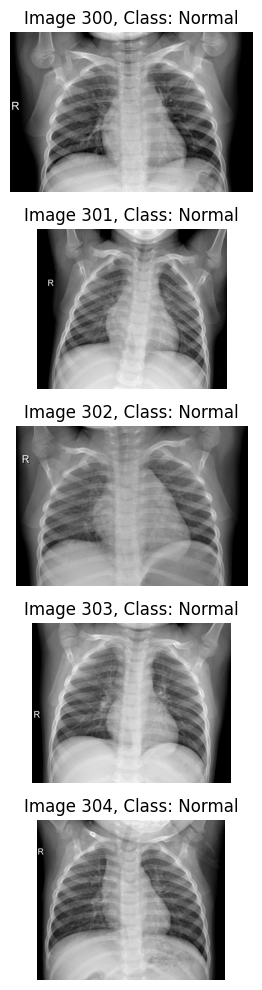

In [16]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_train, start_index=300, num_images=5)

### Analise das imagens médicas da classe "Pneumonia"

In [17]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_test, start_index=3000, num_images=5)

<Figure size 1000x1000 with 0 Axes>

### Explorando os dados do médicos / Definição de funções de distribuição

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens. A função def plot_class_distribution(df):


*   Apresenta  a a distribuição do plot_class_distribution("DATA FRAME SELECIONADO")

In [18]:
def plot_class_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='class')
    plt.title('Distribuição das Classes')
    plt.show()

### Dataframe de treinamento

Analise da distribuição dos dados de treinamento das classes:

*   Normal; e
*   Pneumonia;

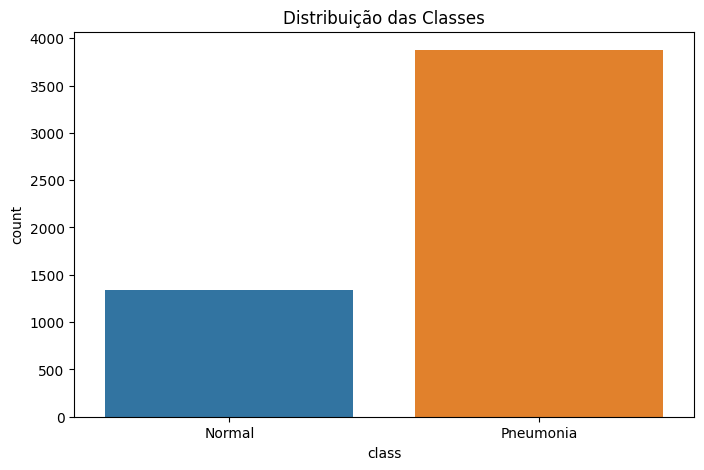

In [19]:
plot_class_distribution(df_train)

### Dataframe de Validação

Analise da distribuição dos dados de validação das classes:

*   Normal; e
*   Pneumonia;



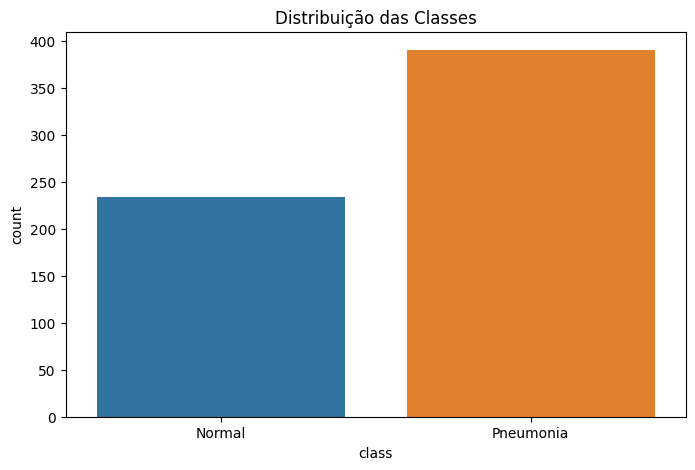

In [20]:
plot_class_distribution(df_test)

### Dataframe de Teste

Analise da distribuição dos dados de teste das classes:

*   Normal; e
*   Pneumonia;



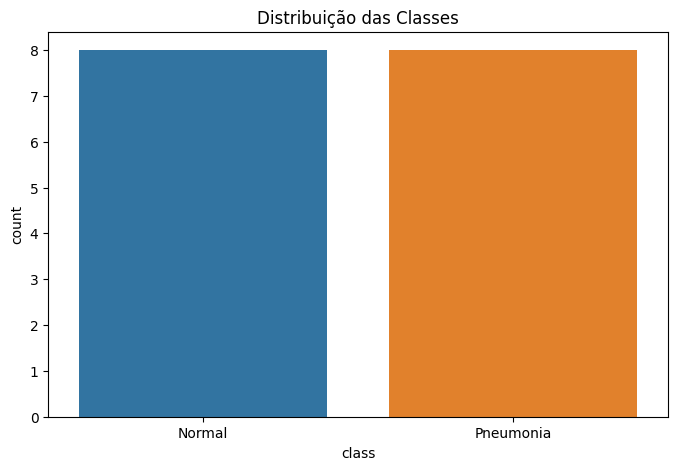

In [21]:
plot_class_distribution(df_val)

# Preparação dos Dados para o Treinamento

Embora os modelos de aprendizado profundo sejam totalmente capazes de lidar com dados multidimensionais, como é o caso de imagens, a aplicação da operação de [reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) para "achatar" as imagens e transformá-las em uma única matriz contínua de pixels é uma prática comum. Essa operação simplifica a estrutura de dados de entrada e pode facilitar o processo de treinamento, especialmente ao lidar com modelos mais simples ou ao iniciar a modelagem.

* No nosso caso específico, uma imagem de dimensões 28x28 pixels é transformada em uma matriz unidimensional de 784 elementos (28x28 = 784). Esta transformação é comumente referida como "nivelamento" da imagem.

* A função `reshape` é uma ferramenta poderosa neste processo, permitindo que reformulemos a estrutura dos nossos dados para se adequar às necessidades do nosso modelo. A operação de reshape é crucial para garantir que os nossos dados de entrada estejam na forma correta antes de alimentá-los no modelo.

Em nosso caso de classificação de imagens, temos duas categorias: 'Normal' e 'Pneumonia'. A ideia é que nosso modelo de aprendizado de máquina entenda que, para uma imagem específica, ou ela é **'Normal' ou 'Pneumonia'**, não existe um "quase Normal" ou "quase Pneumonia".

O atual rótulo das imagens é uma designação de **'Normal' ou 'Pneumonia'**. Como essas categorias formam uma escolha binária, o modelo pode pensar erroneamente que está "próximo" de acertar se adivinhar de forma errada.

Para evitar isso, utilizaremos  a **codificação categórica**. Esta transformação muda os rótulos para que cada rótulo seja uma coleção de todas as categorias possíveis, com o verdadeiro rótulo da imagem marcado como verdadeiro.

Por exemplo, para as categorias 'Normal' e 'Pneumonia', depois da codificação categórica, teríamos algo assim para uma imagem 'Normal':

* 'Normal': Falso (1)
* 'Pneumonia': Verdadeiro (0)

Isso ajuda o modelo a entender que ou uma imagem é **'Normal' ou 'Pneumonia', sem qualquer conceito de proximidade entre as categorias**.

Esse processo é representado pela codificação das label `labels.append(1 if label == 'Pneumonia' else 0)´

In [22]:
# Função para carregar e processar as imagens
def load_and_process_images(df, image_size=(28, 28)):
    images = []
    labels = []
    total_images = df.shape[0]
    for i, (image_path, label) in enumerate(zip(df['image'], df['class'])):
        # Carrega a imagem com a biblioteca PIL
        img = Image.open(image_path)
        #Redimensiona a imagem para 28x28 pixels usando o método resize. (28 x 28)
        img = img.resize(image_size)
        #Converte a imagem para escala de cinza com o método convert('L'). Isso é feito porque as imagens em escala de cinza são mais simples de lidar
        #(uma única camada de intensidades de pixel, em vez de três camadas de cores em imagens coloridas) e são suficientes para muitas tarefas de processamento
        #de imagem e aprendizado de máquina.
        img = img.convert('L')
        # Converte a imagem para um array NumPy
        img_array = np.array(img)
        # Normaliza os pixels (0-255) para o intervalo 0-1
        img_array = img_array / 255.0
        #Achatando a imagem usando reshape(-1). Isso transforma a matriz 2D em uma matriz 1D (um vetor) de elementos.
        #Como o tamanho da imagem é 28x28 pixels, o vetor terá 784 elementos.
        img_array = img_array.reshape(-1)
        # Adiciona ao conjunto de imagens
        images.append(img_array)
        # Converte rótulo e adiciona ao conjunto de rótulos (Conersão de rotulos binária 1 Pneumonia 0 Normal)
        labels.append(1 if label == 'Pneumonia' else 0)

        # Mostrando o progresso
        if (i+1) % 100 == 0 or i+1 == total_images:
            print(f'Processando {i+1} de {total_images} imagens ({(i+1)/total_images*100:.2f}%)')

    return np.array(images), np.array(labels)

### Transformação dos dados

In [23]:
print("Processamento dos Dados de Treinamento:\n")
# Carregando e processando as imagens e rótulos de treinamento
x_train, y_train = load_and_process_images(df_train)
#Redimensionamento para imagem 28x28
#x_train, y_train = load_and_process_images(df_train, image_size=(28, 28))


Processamento dos Dados de Treinamento:

Processando 100 de 5216 imagens (1.92%)
Processando 200 de 5216 imagens (3.83%)
Processando 300 de 5216 imagens (5.75%)
Processando 400 de 5216 imagens (7.67%)
Processando 500 de 5216 imagens (9.59%)
Processando 600 de 5216 imagens (11.50%)
Processando 700 de 5216 imagens (13.42%)
Processando 800 de 5216 imagens (15.34%)
Processando 900 de 5216 imagens (17.25%)
Processando 1000 de 5216 imagens (19.17%)
Processando 1100 de 5216 imagens (21.09%)
Processando 1200 de 5216 imagens (23.01%)
Processando 1300 de 5216 imagens (24.92%)
Processando 1400 de 5216 imagens (26.84%)
Processando 1500 de 5216 imagens (28.76%)
Processando 1600 de 5216 imagens (30.67%)
Processando 1700 de 5216 imagens (32.59%)
Processando 1800 de 5216 imagens (34.51%)
Processando 1900 de 5216 imagens (36.43%)
Processando 2000 de 5216 imagens (38.34%)
Processando 2100 de 5216 imagens (40.26%)
Processando 2200 de 5216 imagens (42.18%)
Processando 2300 de 5216 imagens (44.10%)
Process

In [24]:
print("\nProcessamento dos Dados de Validação:\n")
# Carregando e processando as imagens e rótulos de validação
x_valid, y_valid = load_and_process_images(df_val)
#Redimensionamento para imagem 28x28
#x_valid, y_valid = load_and_process_images(df_valid, image_size=(28, 28))



Processamento dos Dados de Validação:

Processando 16 de 16 imagens (100.00%)


In [25]:
print("\nProcessamento dos Dados de teste:\n")
# Carregando e processando as imagens e rótulos de teste
x_test, y_test = load_and_process_images(df_test)
#Redimensionamento para imagem 28x28
#x_test, y_test = load_and_process_images(df_test, image_size=(28, 28))


Processamento dos Dados de teste:

Processando 100 de 624 imagens (16.03%)
Processando 200 de 624 imagens (32.05%)
Processando 300 de 624 imagens (48.08%)
Processando 400 de 624 imagens (64.10%)
Processando 500 de 624 imagens (80.13%)
Processando 600 de 624 imagens (96.15%)
Processando 624 de 624 imagens (100.00%)


### Validação da transformação

Nessa etapa verificamos se os dataframes de treinamento e teste foram corretamente transformados.


In [26]:
#O modelo espera uma entrada de shape (None, 28, 28, 1)
#(que é o formato para uma imagem em escala de cinza de 28x28), em vez de uma entrada de shape (None, 784).
#Então vamos achatalas os vetores de 784 elementos, para estarem na forma de matrizes 28x28.
# Remodelando os dados de entrada para a forma correta
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)

In [27]:
x_train.shape

(5216, 28, 28, 1)

In [28]:
x_train[0]

array([[[0.29803922],
        [0.47058824],
        [0.59215686],
        [0.40784314],
        [0.25882353],
        [0.07843137],
        [0.00784314],
        [0.        ],
        [0.1254902 ],
        [0.49803922],
        [0.71764706],
        [0.87843137],
        [0.83137255],
        [0.8       ],
        [0.78431373],
        [0.59607843],
        [0.40784314],
        [0.10980392],
        [0.        ],
        [0.        ],
        [0.05098039],
        [0.26666667],
        [0.43137255],
        [0.59215686],
        [0.50588235],
        [0.41568627],
        [0.20784314],
        [0.01176471]],

       [[0.28235294],
        [0.43529412],
        [0.58039216],
        [0.43529412],
        [0.32156863],
        [0.19607843],
        [0.05882353],
        [0.        ],
        [0.09411765],
        [0.37254902],
        [0.54509804],
        [0.69019608],
        [0.75294118],
        [0.68235294],
        [0.66666667],
        [0.52156863],
        [0.31764706],
        

Agora podemos ver que os valores são todos valores de ponto flutuante entre **0.0 e 1.0**:

In [29]:
x_train.dtype

dtype('float64')

In [30]:
x_train.min()

0.0

In [31]:
x_train.max()

1.0

In [32]:
# Vamos pegar as primeiras 5 imagens
first_5_images = x_train[:5]

# Transpor para que cada imagem seja uma coluna e fique mais vacil de visualizar a transformação
first_5_images_transposed = np.transpose(first_5_images)

# Imprimir cada linha
for row in first_5_images_transposed:
    print(row)

[[[0.29803922 0.         0.08235294 0.         0.1372549 ]
  [0.28235294 0.         0.09019608 0.         0.11764706]
  [0.26666667 0.         0.16470588 0.         0.09411765]
  ...
  [0.         0.18039216 0.         0.         0.        ]
  [0.         0.22745098 0.         0.         0.        ]
  [0.         0.29019608 0.5254902  0.         0.        ]]

 [[0.47058824 0.13333333 0.32941176 0.07843137 0.27843137]
  [0.43529412 0.11372549 0.16862745 0.05490196 0.28235294]
  [0.4        0.08235294 0.07058824 0.04313725 0.29019608]
  ...
  [0.         0.46666667 0.         0.01568627 0.        ]
  [0.         0.50588235 0.         0.02745098 0.        ]
  [0.         0.47843137 0.08235294 0.04705882 0.        ]]

 [[0.59215686 0.26666667 0.38039216 0.25882353 0.36862745]
  [0.58039216 0.25490196 0.40392157 0.24705882 0.36470588]
  [0.54117647 0.21176471 0.39607843 0.22352941 0.40784314]
  ...
  [0.01568627 0.62745098 0.21568627 0.36078431 0.08627451]
  [0.02745098 0.54901961 0.2235294

In [33]:
y_train[0:9]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

Validação do Array Validação da Etapa de Encodificação de
* 0 para normal; e
* 1 para Pneumonia;
* Validação Conforme Array **"y_train[0:9]"** na linha anterior.

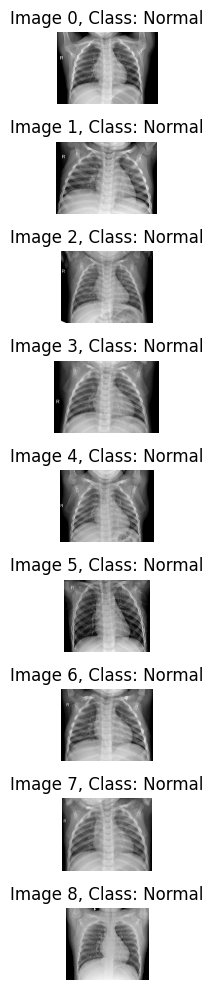

In [34]:
plot_images(df_train, start_index=0, num_images=9)

# Criação do Modelo

Com os dados prontos, construiremos um modelo básico composto por camadas. O modelo tem 3 partes:
* Camada de entrada: recebe os dados no formato esperado.
* Camadas ocultas: formadas por neurônios que afetam a estimativa da rede através de seus pesos, valores ajustados ao longo do treinamento.
* Camada de saída: representa a estimativa da rede para uma entrada específica.

Usamos a classe Dense do Keras para criar uma camada densamente conectada, onde cada neurônio afeta todos os da próxima camada. Definimos o número de neurônios com o argumento `units`. A função de ativação `relu` permite que a rede faça suposições complexas sobre os dados. `input_shape` especifica o formato dos dados de entrada.

Por fim, adicionamos uma camada de saída com função de ativação `softmax`, resultando em valores de probabilidade entre 0 e 1 que somam 1. Para a nossa tarefa de classificar uma imagem em 10 categorias possíveis, teremos 10 saídas, cada uma representando a probabilidade da imagem pertencer a essa classe.

### Compilando o Model

### COPILAÇÃO I

### COPILAÇÃO II

In [45]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

#reset da sessão e do modelo
tf.keras.backend.clear_session()

# Definindo o modelo
model = Sequential()

# Camada de entrada - Nós precisamos fazer a entrada de imagens em formato (altura, largura, canais)
# Para imagens em escala de cinza, a quantidade de canais é 1. Se fossem imagens coloridas, seriam 3 (R, G, B)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten()) # Achatamos as saídas 2D das camadas de convolução para 1D para a entrada nas camadas densas

# Camada de entrada densa
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.01)) # Reduzido a taxa de dropout

# Adicionar mais uma camada oculta para aumentar a complexidade do modelo
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.01)) # Reduzido a taxa de dropout

# Adicionar mais uma camada oculta para aumentar a complexidade do modelo
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.01)) # Reduzido a taxa de dropout

# Camada de saída
model.add(Dense(1, activation='sigmoid'))

In [46]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

# Treinando o Modelo

Com os dados de treinamento, validação e o modelo preparados, é hora de ajustar o modelo. Esse processo, também chamado de treinamento, adapta o modelo aos dados. Usamos o método `fit` do Keras, que requer:

* Dados de treinamento e respectivos rótulos
* Número de iterações completas no conjunto de treinamento (épocas)
* Dados de validação ou teste e seus rótulos

Ao executar o treinamento, o modelo aprenderá e ajustará sua forma para melhor representar os dados.

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
#se apos 10 epocs a taxa de perda não começar a diminuir o modelo será interrompido
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
#Treinamento do modelo
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Epoch 1/50
82/82 [==============================] - 6s 11ms/step - loss: 0.2748 - accuracy: 0.8980 - val_loss: 0.8098 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0925 - accuracy: 0.9749 - val_loss: 1.5518 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0599 - accuracy: 0.9824 - val_loss: 2.2608 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0406 - accuracy: 0.9896 - val_loss: 2.3962 - val_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 2.2137 - val_accuracy: 0.5000
Epoch 6/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0212 - accuracy: 0.9939 - val_loss: 1.2236 - val_accuracy: 0.6250
Epoch 7/50
82/82 [==============================] - 1s 8ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.8263 - val_accuracy: 0.6875
Epoch 8/50
82/82 [=

# Plotando os Resultados

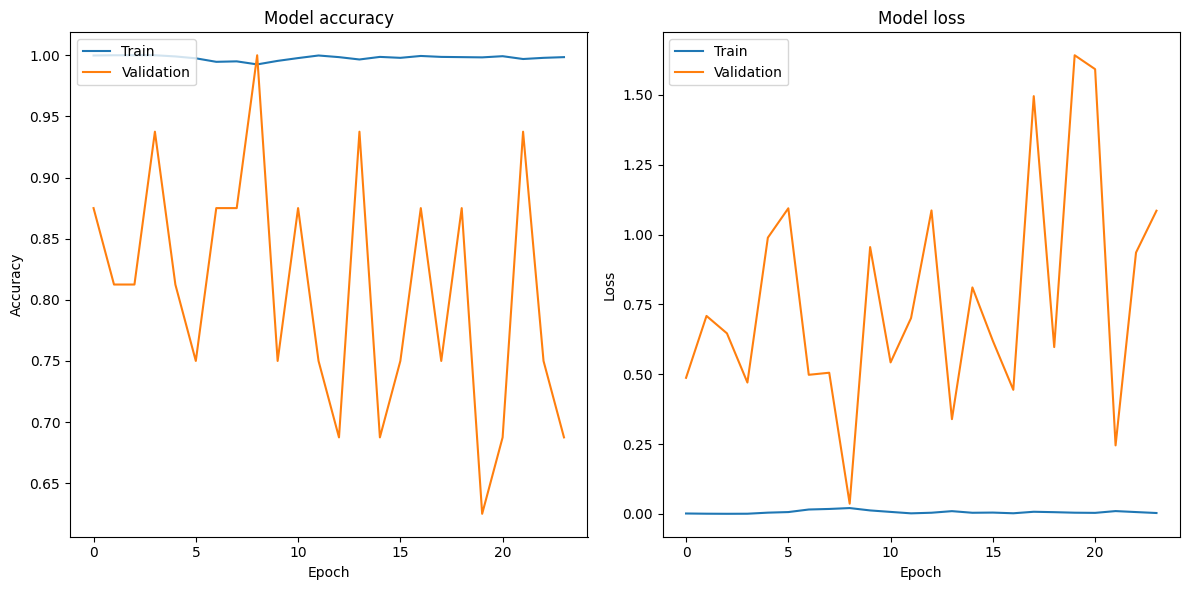

In [44]:
#COPILAÇÃO I

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

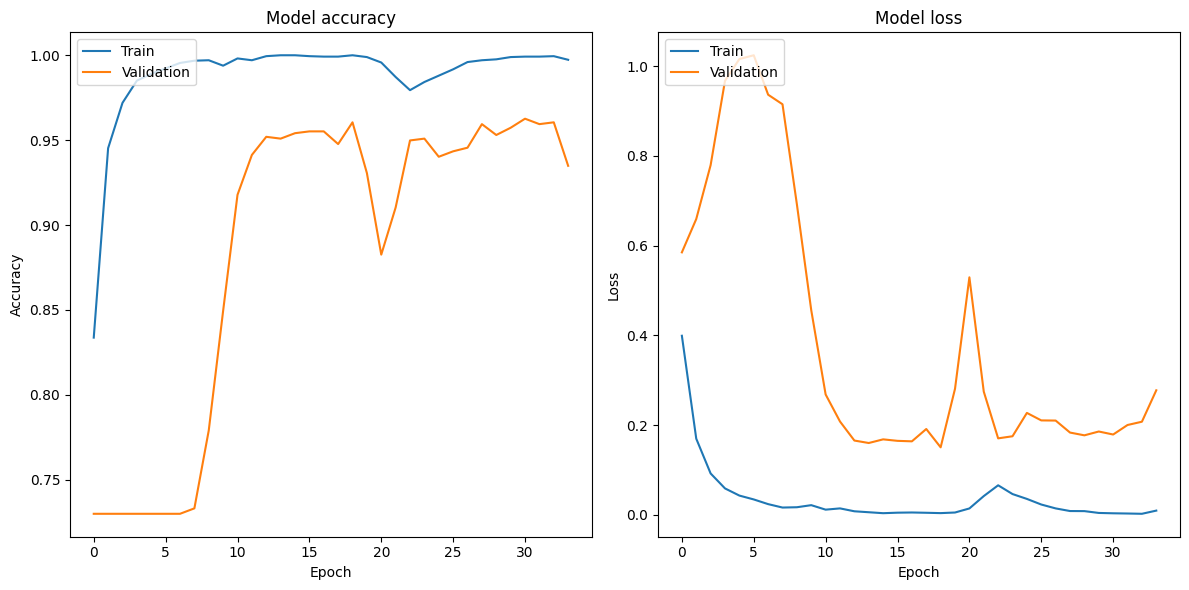

In [ ]:
#COPILAÇÃO II

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()